In [4]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
import paths
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

print("Paths:")
for k,v in paths.path.items():
    print(" path.%s: %s" % (k,v))

Paths:
 path.notebook_root: /Users/trafferty/data/notebooks
 path.images_root: /Users/trafferty/data/images
 path.scripts_root: /Users/trafferty/data/scripts
 path.results_root: /Users/trafferty/data/results
 path.tmp_dir: /Users/trafferty/data/tmp
 path.projects_root: /Users/trafferty/data/projects


In [12]:
# Scale 16-bit image to 8-bit
def convert16BitTo8Bit(img16):
    # Scale ref to 8-bit
    minLevel = np.min(np.min(img16))
    img8 = (img16.copy() - minLevel);
    maxLevel = np.max(np.max(img8))
    img8 = (img8*255.0/maxLevel).astype(np.uint8)
    return img8


In [13]:
def variance_of_laplacian(img):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(img, cv2.CV_64F).var()


In [14]:
imgs = {}
imgs["+0"  ] = paths.images_root+'/dif/focus/+0/2017-09-29_09.22.41/DispenserOpt_00005_2017-09-29_09.22.52.png'
#imgs["+100"] = paths.images_root+'/dif/focus/+100um/2017-09-29_09.24.18/DispenserOpt_00005_2017-09-29_09.24.30.png'
imgs["+10" ] = paths.images_root+'/dif/focus/+10um/2017-09-29_09.23.27/DispenserOpt_00005_2017-09-29_09.23.38.png'
imgs["+20" ] = paths.images_root+'/dif/focus/+20um/2017-09-29_09.25.05/DispenserOpt_00005_2017-09-29_09.25.15.png'
imgs["+30" ] = paths.images_root+'/dif/focus/+30um/2017-09-29_09.25.38/DispenserOpt_00005_2017-09-29_09.25.49.png'
imgs["+40" ] = paths.images_root+'/dif/focus/+40um/2017-09-29_09.26.13/DispenserOpt_00005_2017-09-29_09.26.24.png'
imgs["-10" ] = paths.images_root+'/dif/focus/-10um/2017-09-29_09.28.59/DispenserOpt_00005_2017-09-29_09.29.09.png'
imgs["-20" ] = paths.images_root+'/dif/focus/-20um/2017-09-29_09.29.44/DispenserOpt_00005_2017-09-29_09.29.54.png'
imgs["-30" ] = paths.images_root+'/dif/focus/-30um/2017-09-29_09.31.29/DispenserOpt_00005_2017-09-29_09.31.39.png'
imgs["-40" ] = paths.images_root+'/dif/focus/-40um/2017-09-29_09.32.16/DispenserOpt_00005_2017-09-29_09.32.27.png'


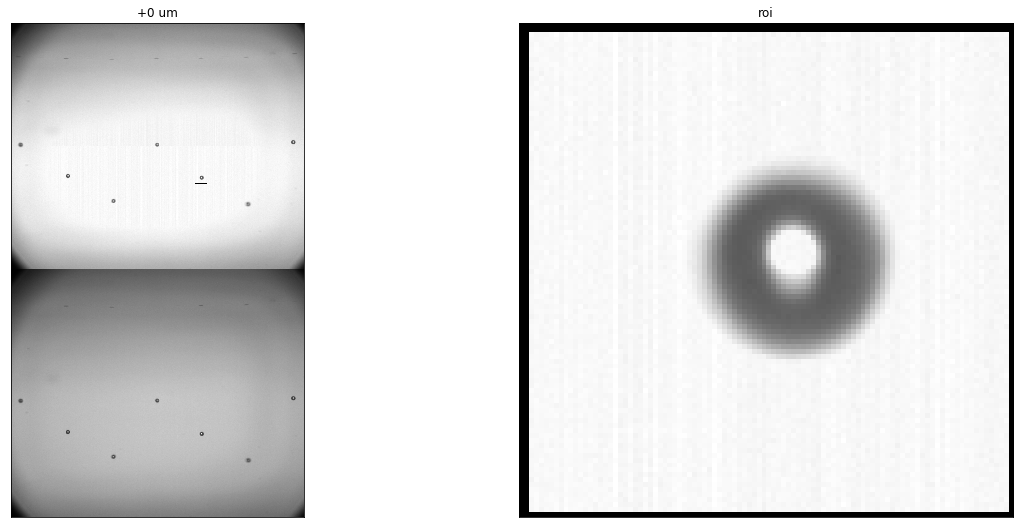

In [15]:
k = "+0"
img16 = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
img16.dtype
img8 = convert16BitTo8Bit(img16)

h,w = 100, 100
sx = 1610
sy = 1310
roi = img16[sy:sy+h, sx:sx+w]  #np slice: [startY:endY, startX:endX]
cv2.rectangle(img16, (sx, sy), (sx+w, sy+h), (0,0,0), 2) # two corners: (startX, startY), (endX, endY)

util.plot_imgs([(convert16BitTo8Bit(img16), "%s um" % (k)), (convert16BitTo8Bit(roi), "roi")])

In [16]:
def findBLOBs(img):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 150;

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = .8

    # # Filter by Convexity
    params.filterByConvexity = False
    # params.minConvexity = 0.87

    # # Filter by Inertia
    params.filterByInertia = False
    # params.minInertiaRatio = 0.9

    params.filterByColor = False
    params.filterByArea = True
#     params.minArea = 4 * np.pi
#     params.maxArea = 100 * np.pi
    params.minArea = 20
    params.maxArea = 500

    detector = cv2.SimpleBlobDetector_create(params)
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

In [46]:
def findROI(img8, num_cols, coi, debug=True):
    plot_list = []
    
    rows,cols = img8.shape
    col_width = int(cols/num_cols)

    h,w = rows, col_width
    sx = int(col_width * coi)
    col_img = img8[0:rows, sx:sx+col_width]  #np slice: [startY:endY, startX:endX]
    #if debug: plot_list.append((col_img, "nozzle on col# %d" %(coi+1)))

    keypoints = findBLOBs(col_img)
    if debug: print( "[findROI] num keypoints found: ", len(keypoints))

    if len(keypoints):
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        #roi_with_keypoints = cv2.drawKeypoints(roi, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        kp = keypoints[0]
        x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
        if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

        roi = col_img.copy()[y-75:y+75, 1:col_width]

        if debug:
            plot_list.append( (roi,'roi:%s'%tag) )
            cv2.circle(col_img, (x, y), int(dia/2), (0,0,255),2)
            cv2.line(col_img, (x, y-dia), (x, y+dia), (0,0,255), 3)
            cv2.line(col_img, (x-dia, y), (x+dia, y), (0,0,255), 3)
            #plot_list.append( (col_img,'Keypoints') )
        #cv2.rectangle(img8, (sx, sy), (sx+w, sy+h), (0,0,0), 10) # two corners: (startX, startY), (endX, endY)                

    if debug:
        util.plot_imgs(plot_list)
    
    if len(keypoints):
        return roi
    else:
        return None

In [ ]:
plot_list = []
k = "+40"
img = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
rows,cols = img.shape
img16 = img[ int(rows/8):int(rows/2)-100, 0:cols  ]

img8 = convert16BitTo8Bit(img16)
histr = cv2.calcHist([img8],[0],None,[256],[0,256])
plt.plot(histr)


# plot_list.append((img8, "%s um" % (k)))

num_cols = 7
coi = 1    # 'column of interest', zero-based

roi = findROI(img8, num_cols, coi, tag=k, debug=True)


Finding ROI for img +0
[findROI] num keypoints found:  1
[findROI] (179, 535), dia: 19, area: 59.690260
Finding ROI for img -40
[findROI] num keypoints found:  0
Finding ROI for img +30
[findROI] num keypoints found:  1
[findROI] (183, 538), dia: 22, area: 69.115038
Finding ROI for img +40
[findROI] num keypoints found:  2
[findROI] (182, 531), dia: 10, area: 31.415927
Finding ROI for img +10
[findROI] num keypoints found:  1
[findROI] (186, 530), dia: 13, area: 40.840704
Finding ROI for img -20
[findROI] num keypoints found:  1
[findROI] (184, 522), dia: 12, area: 37.699112
Finding ROI for img -30
[findROI] num keypoints found:  0
Finding ROI for img +20
[findROI] num keypoints found:  1
[findROI] (184, 539), dia: 13, area: 40.840704
Finding ROI for img -10
[findROI] num keypoints found:  1
[findROI] (183, 520), dia: 17, area: 53.407075
Found 7 ROIs


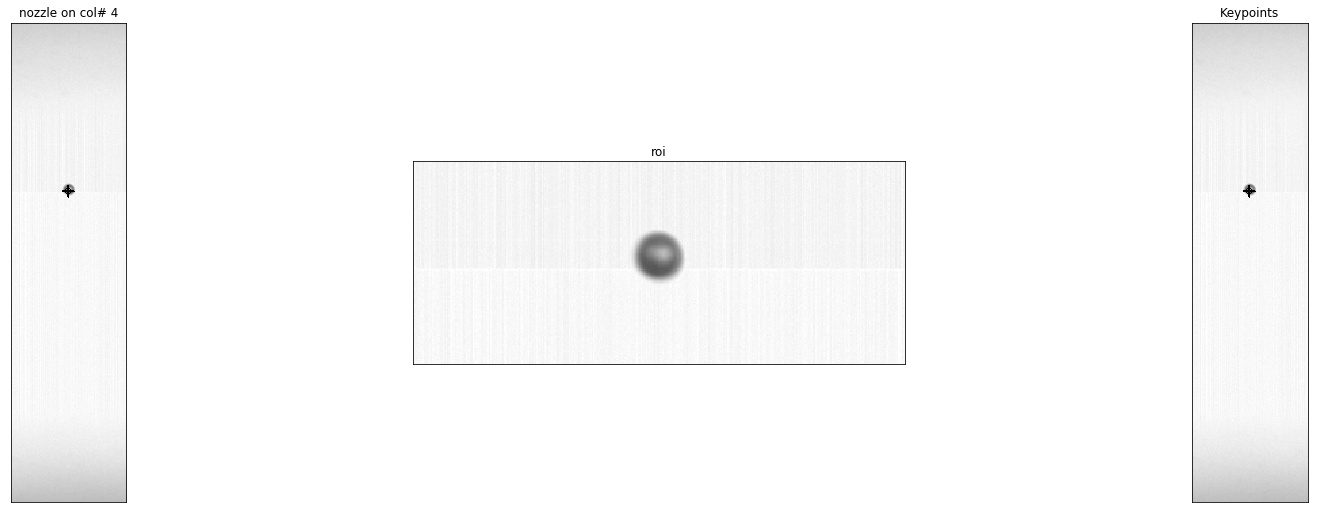

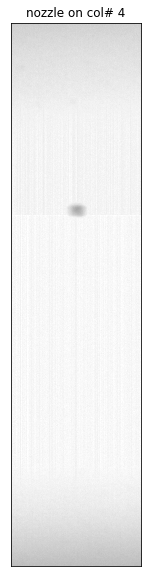

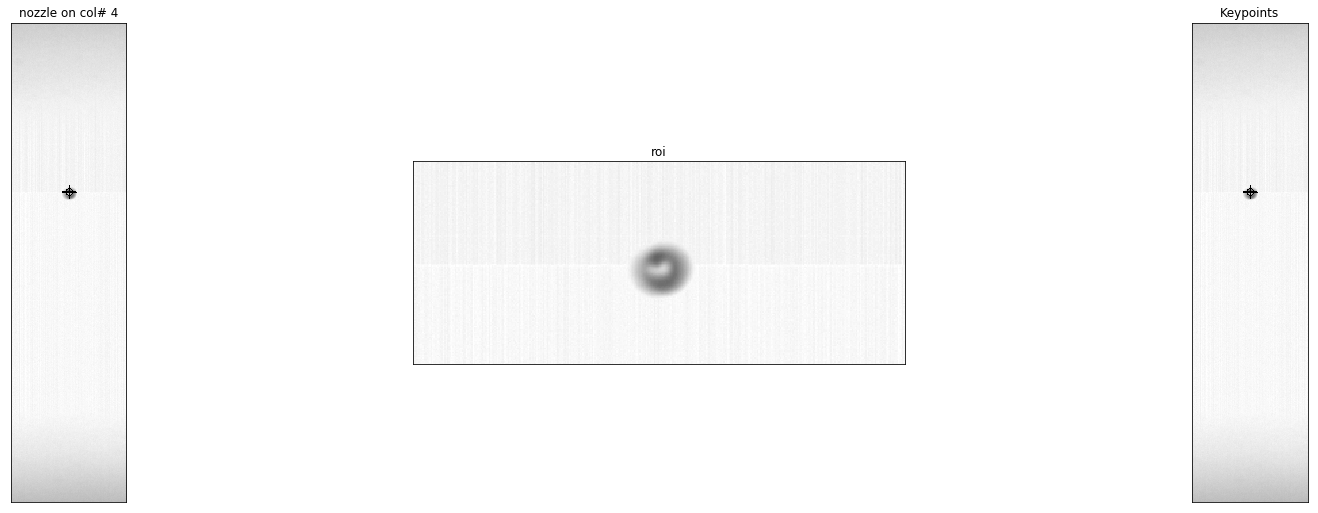

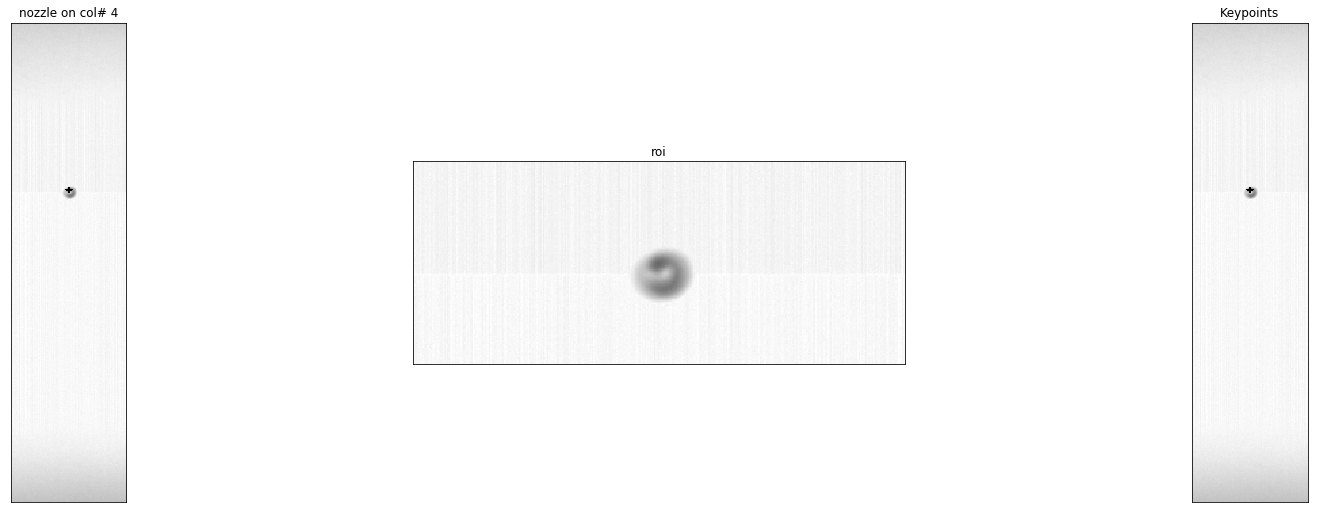

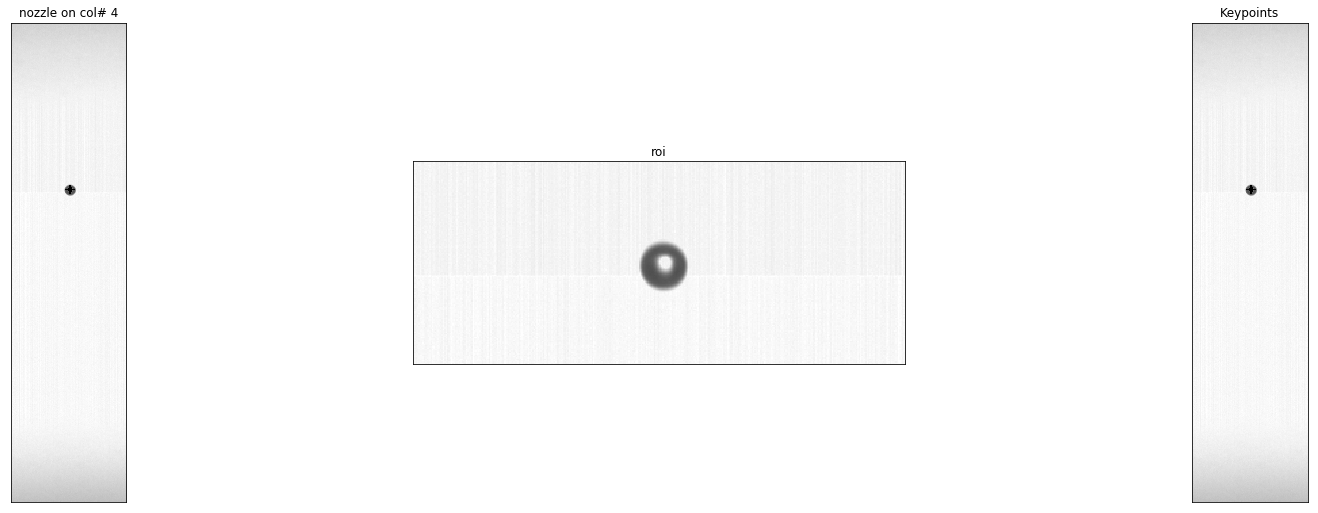

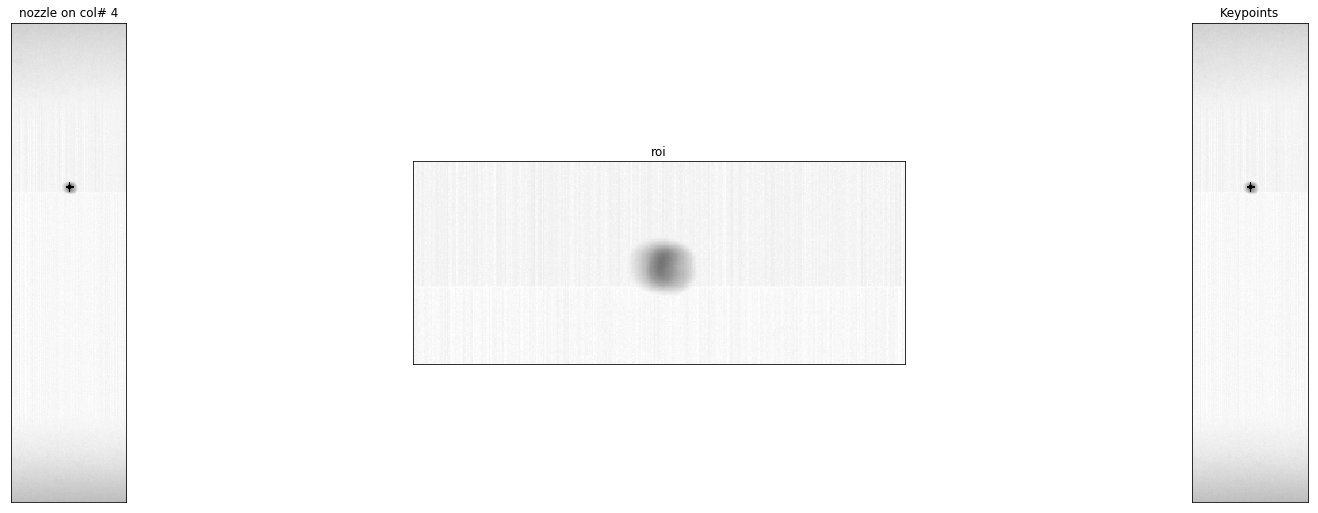

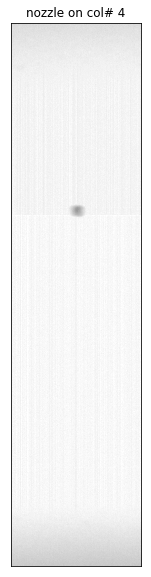

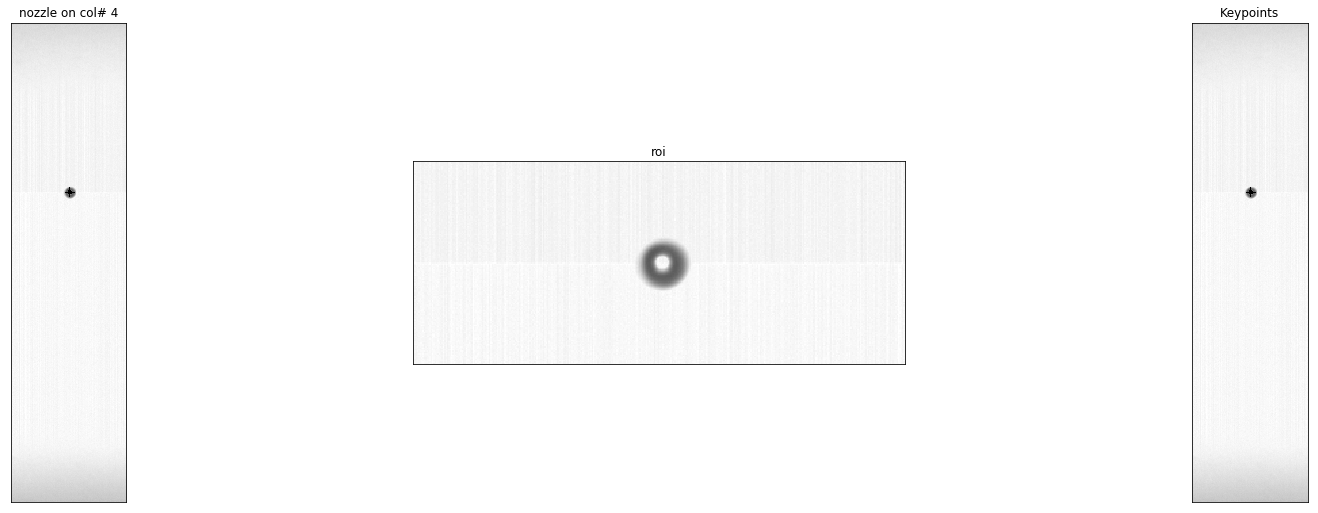

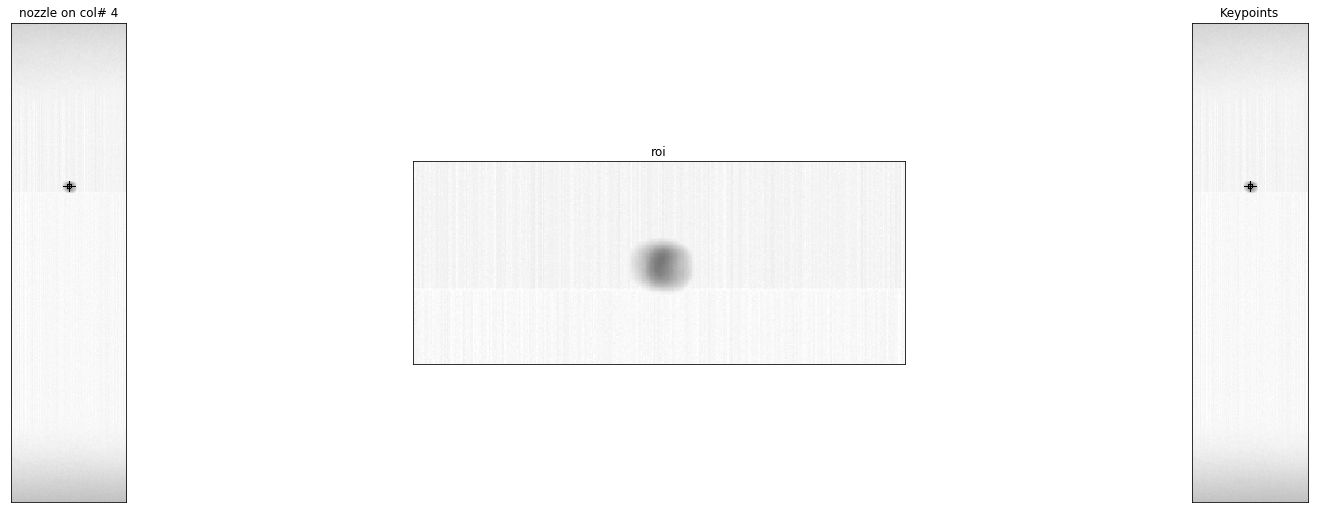

In [45]:
img_list = []

num_cols = 7
coi = 3    # 'column of interest', zero-based

for k,v in imgs.items():
    print("Finding ROI for img %s" % (k))
    #img16 = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)

    img = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
    rows,cols = img.shape
    img16 = img[ int(rows/8):int(rows/2)-100, 0:cols  ]
    rows,cols = img16.shape

    img8 = convert16BitTo8Bit(img16)
    cv2.putText(img8, k, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255), 1)

    roi = findROI(img8, num_cols, coi, debug=True)
    if roi is not None:
        img_list.append( (roi, int(k)) )

    
img_list = sorted(img_list, key=lambda x: x[1])
print("Found %d ROIs" % len(img_list))

-20um: 803742
-10um: 819913
0um: 1252679
10um: 2622141
20um: 1659648
30um: 1005863
40um: 961242


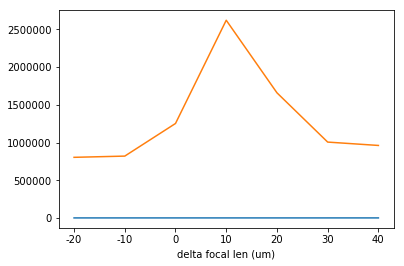

In [43]:
results = []
plot_list = []
ksize=7
for img in img_list:
    img2 = cv2.Laplacian(img[0], cv2.CV_64F, ksize=ksize)
    focus_measure = img2.var()
    plot_list.append( ((img2), "%dum: %d" % (img[1], int(focus_measure)) ) )
    results.append( (img[1], int(focus_measure)) )
    print("%dum: %d" % (img[1], int(focus_measure)))

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()
#util.plot_imgs(plot_list, max_cols = 2)